# Experiments wi SA-PINN masks

Эта часть будет относена к приложению как эксперименты над выбором маски весов лосса. В оригинальной [статье]() на выбор представляется два вида маски: полиноминальная и сигмоидная. Для выбора вида маски здесь будут проведены эксперименты с использованием двух моделей: с использованием полиноминальной маски и с использованием сигмоидной маски, а также с частным видом полиноминальной маски - линейной. Все эксперименты будут проводиться с использование FFR, так как она на момент экспериментов показала себя более эффективной, чем базовая PINN.

In [1]:
import sys
import os
import json
sys.path.append("..")

import torch
import torch.autograd as autograd
from torch.optim.lr_scheduler import LambdaLR, StepLR
import torch.optim as optim
import random 
import numpy as np

from tasks.burgers_1d import Burgers1D
from models.sapinn import SA_PINN
from models.pinn import PINN
from models.utils.schedulers import LambdaScheduler
from models.utils.masks import PolynomialMask, SigmoidMask, LinearMask
from common.train_functions import *
from common.plotting import *
from common.saving_results import *

In [2]:
print("CUDA Version:", torch.version.cuda)
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))

CUDA Version: 12.8
True
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
# Fix random number generators
seed = 42
torch.manual_seed(seed)  # For PyTorch
random.seed(seed)        # For random
np.random.seed(seed)     # For NumPy

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
viscosity = 0.01 / np.pi  # Viscosity
burgers_1d = Burgers1D(nu=viscosity)

In [6]:
# Set number of data points
N_0 = 50
N_b = 50
N_d = 0
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

In [7]:
# Set boundaries
lb = torch.tensor([tmin, xmin], dtype=torch.float32, requires_grad=False)  # Lower bounds
ub = torch.tensor([tmax, xmax], dtype=torch.float32, requires_grad=False)  # Upper bounds

# Generate points for initial conditions
t_0 = torch.ones((N_0, 1), dtype=torch.float32, requires_grad=True) * lb[0]
x_0 = torch.rand((N_0, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)

# Compute initial condition at points x_0
u_0 = burgers_1d.initial_conditions(x_0)

# Generate points for boundary conditions
t_b = torch.rand((N_b, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.full((N_b, 1), 0.5, dtype=torch.float32))
x_b.requires_grad_(True)  # Set requires_grad=True for x_b
X_b = torch.cat([t_b, x_b], dim=1)

# Compute boundary condition at points (t_b, x_b)
u_b = burgers_1d.boundary_conditions(t_b)

# Generate points for collocation
t_r = torch.rand((N_r, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_r = torch.rand((N_r, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_r = torch.cat([t_r, x_r], dim=1)

## Plot generated points

Text(0.5, 1.0, 'Positions of collocation points and boundary data')

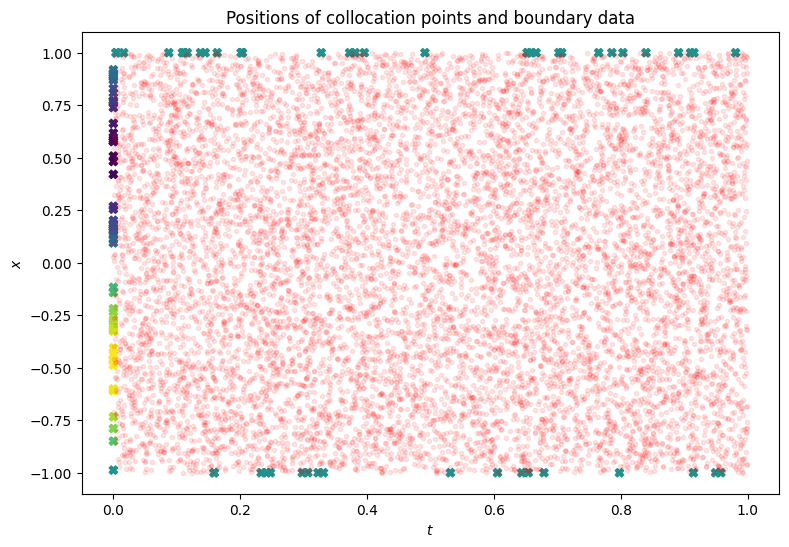

In [8]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0.detach().numpy(), x_0.detach().numpy(), c=u_0.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_b.detach().numpy(), x_b.detach().numpy(), c=u_b.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_r.detach().numpy(), x_r.detach().numpy(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
# plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

# Common hyperparameters for all models

In [9]:
N = 500
rff_features = 20
rff_layers = 9
lambda_step_size = 100
lambda_lr = 1e-4
weight_gamma = 0.85
max_epoch = 10000

# RFF-PINN without SA

In [10]:
# Set training parameters
rff_pinn = PINN(
    input_dim=2,
    rff_features=rff_features,
    output_dim=1,
    hidden_layers= 9 * [2 * rff_features + 2],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(rff_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma)
}

In [11]:
rff_pinn.to(device)
train_loss, eval_losses = train_pinn(
    max_epoch, 
    rff_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

C:\Users\ritka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 50/10000, PINN Loss: 0.19151413440704346, True Loss: 0.1926540732383728
Epoch: 100/10000, PINN Loss: 0.158819317817688, True Loss: 0.1588164120912552
Epoch: 150/10000, PINN Loss: 0.15752921998500824, True Loss: 0.15750211477279663
Epoch: 200/10000, PINN Loss: 0.15592339634895325, True Loss: 0.15588316321372986
Epoch: 250/10000, PINN Loss: 0.1526426523923874, True Loss: 0.15252265334129333
Epoch: 300/10000, PINN Loss: 0.14499717950820923, True Loss: 0.14009016752243042
Epoch: 350/10000, PINN Loss: 0.11193253844976425, True Loss: 0.11136230081319809
Epoch: 400/10000, PINN Loss: 0.08064451813697815, True Loss: 0.07706920802593231
Epoch: 450/10000, PINN Loss: 0.06847994029521942, True Loss: 0.1107267290353775
Epoch: 500/10000, PINN Loss: 0.04824957996606827, True Loss: 0.044401854276657104
Epoch: 550/10000, PINN Loss: 0.03782784193754196, True Loss: 0.035197287797927856
Epoch: 600/10000, PINN Loss: 0.031377993524074554, True Loss: 0.05637314170598984
Epoch: 650/10000, PINN Loss: 0.0

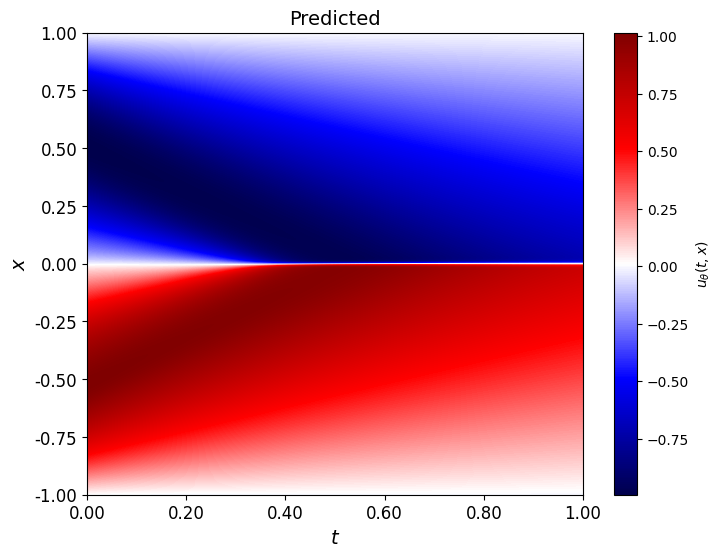

In [12]:
rff_pinn.to("cpu")
T, X, U = compute_approximation_2d(rff_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

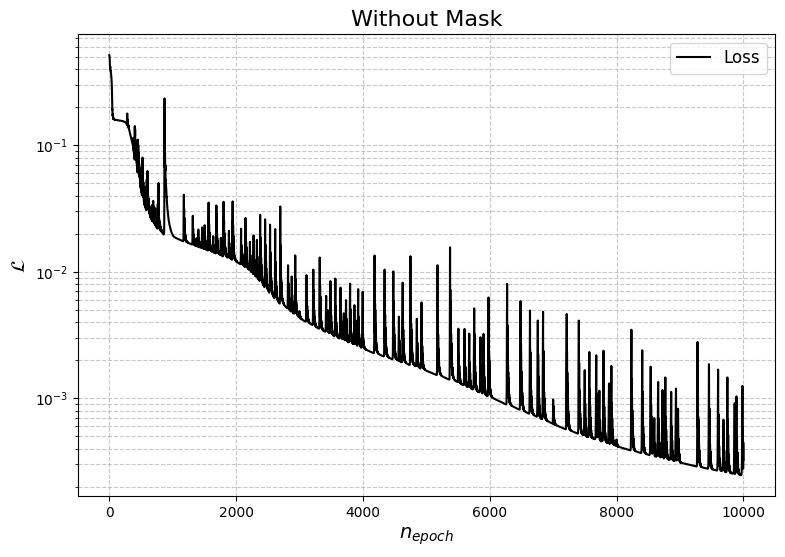

In [13]:
plot_loss(eval_losses, title="Without Mask")

In [14]:
save_u_results(T, X, U, os.path.join("..", "data", "sapinn_mask", "without.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "sapinn_mask", "without.json"))
save_model(rff_pinn, os.path.join("..", "saved_models", "sapinn_mask", "without.pt"))

# SA-PINN with polynomial mask function

In [20]:
# Set training parameters
poly_name = "Polynomial Mask"
poly_sapinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    rff_features=rff_features,
    activation=torch.nn.Tanh(),
    mask_class=PolynomialMask,
    hidden_layers= 9 * [rff_features * 2 + 2],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizers = {
    "model": optim.Adam(poly_sapinn.u_model.parameters(), lr=1e-3),
    "lambdas_pde": optim.Adam([poly_sapinn.lambdas_pde], lr=lambda_lr),
    "lambdas_ics": optim.Adam([poly_sapinn.lambdas_ics], lr=lambda_lr),
    "lambdas_bcs": optim.Adam([poly_sapinn.lambdas_bcs], lr=lambda_lr)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9)
}

In [21]:
poly_sapinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    poly_sapinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

Epoch: 50/10000, PINN Loss: 0.20754635334014893, True Loss: 0.19834572076797485
Epoch: 100/10000, PINN Loss: 0.15623590350151062, True Loss: 0.15611782670021057
Epoch: 150/10000, PINN Loss: 0.15369099378585815, True Loss: 0.1536153256893158
Epoch: 200/10000, PINN Loss: 0.1432662010192871, True Loss: 0.1427922546863556
Epoch: 250/10000, PINN Loss: 0.11833815276622772, True Loss: 0.1179988905787468
Epoch: 300/10000, PINN Loss: 0.10562731325626373, True Loss: 0.10642370581626892
Epoch: 350/10000, PINN Loss: 0.09767398238182068, True Loss: 0.09701137244701385
Epoch: 400/10000, PINN Loss: 0.10065390914678574, True Loss: 0.10794204473495483
Epoch: 450/10000, PINN Loss: 0.05600210279226303, True Loss: 0.054889027029275894
Epoch: 500/10000, PINN Loss: 0.05695644021034241, True Loss: 0.052222803235054016
Epoch: 550/10000, PINN Loss: 0.03737406060099602, True Loss: 0.03754951059818268
Epoch: 600/10000, PINN Loss: 0.03814168646931648, True Loss: 0.03432728722691536
Epoch: 650/10000, PINN Loss: 0.

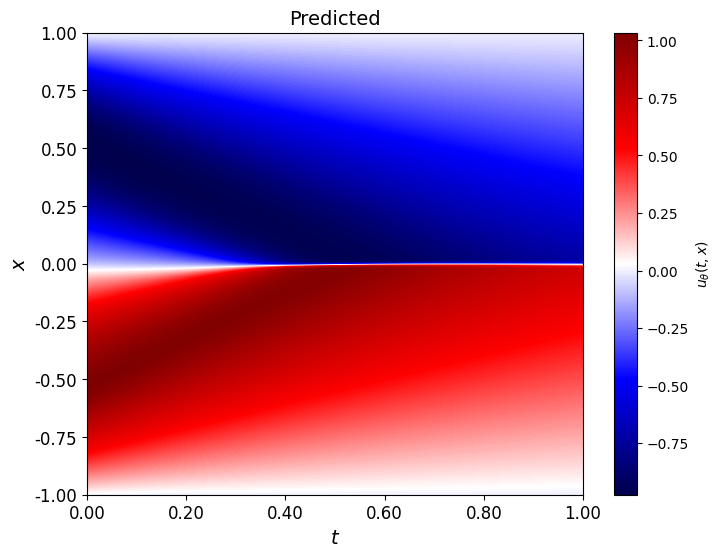

In [22]:
N = 500
poly_sapinn.to("cpu")
T, X, U = compute_approximation_2d(poly_sapinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

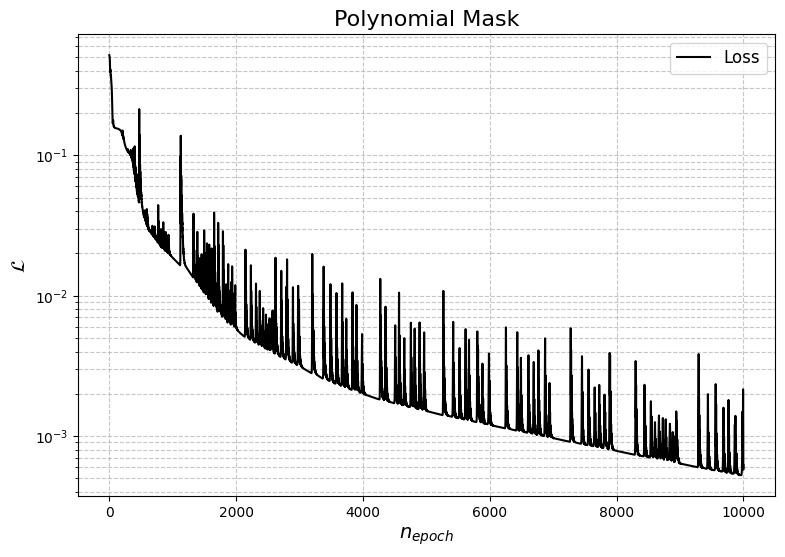

In [23]:
plot_loss(eval_loss, title=poly_name)

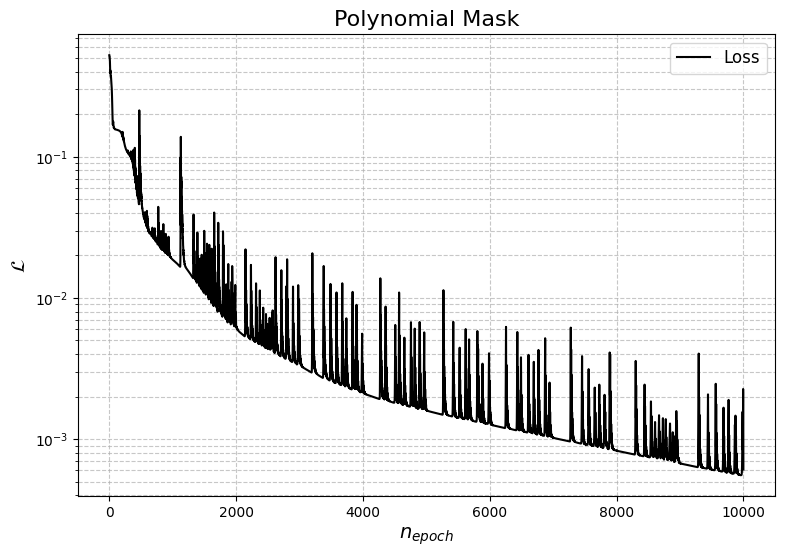

In [24]:
plot_loss(train_loss, title=poly_name)

In [25]:
save_u_results(T, X, U, os.path.join("..", "data", "sapinn_mask", "poly.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "sapinn_mask", "poly.json"))
save_model(poly_sapinn, os.path.join("..", "saved_models", "sapinn_mask", "poly.pt"))

# SAPINN with sigmoid mask function

In [26]:
# Set training parameters
sigm_name = "Sigmoid Mask"
sigm_sapinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    rff_features=rff_features,
    activation=torch.nn.Tanh(),
    mask_class=SigmoidMask,
    hidden_layers= 9 * [2 * rff_features + 2],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizers = {
    "model": optim.Adam(sigm_sapinn.u_model.parameters(), lr=1e-3),
    "lambdas_pde": optim.Adam([sigm_sapinn.lambdas_pde], lr=lambda_lr),
    "lambdas_ics": optim.Adam([sigm_sapinn.lambdas_ics], lr=lambda_lr),
    "lambdas_bcs": optim.Adam([sigm_sapinn.lambdas_bcs], lr=lambda_lr)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9)
}

In [27]:
sigm_sapinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    sigm_sapinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

Epoch: 50/10000, PINN Loss: 0.29347530007362366, True Loss: 0.29256945848464966
Epoch: 100/10000, PINN Loss: 0.15583914518356323, True Loss: 0.1586524248123169
Epoch: 150/10000, PINN Loss: 0.15227030217647552, True Loss: 0.1549435555934906
Epoch: 200/10000, PINN Loss: 0.13812386989593506, True Loss: 0.13891294598579407
Epoch: 250/10000, PINN Loss: 0.10712754726409912, True Loss: 0.10871294140815735
Epoch: 300/10000, PINN Loss: 0.09641857445240021, True Loss: 0.10071088373661041
Epoch: 350/10000, PINN Loss: 0.07174819707870483, True Loss: 0.06871141493320465
Epoch: 400/10000, PINN Loss: 0.0497475266456604, True Loss: 0.055790286511182785
Epoch: 450/10000, PINN Loss: 0.04382318630814552, True Loss: 0.045135170221328735
Epoch: 500/10000, PINN Loss: 0.0378308966755867, True Loss: 0.041972458362579346
Epoch: 550/10000, PINN Loss: 0.03466867655515671, True Loss: 0.03951290249824524
Epoch: 600/10000, PINN Loss: 0.03113710880279541, True Loss: 0.033329613506793976
Epoch: 650/10000, PINN Loss: 

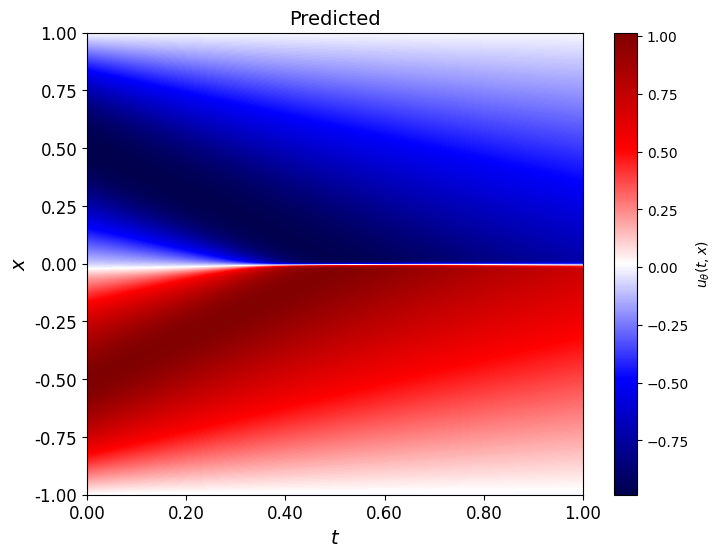

In [28]:
N = 500
sigm_sapinn.to("cpu")
T, X, U = compute_approximation_2d(sigm_sapinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

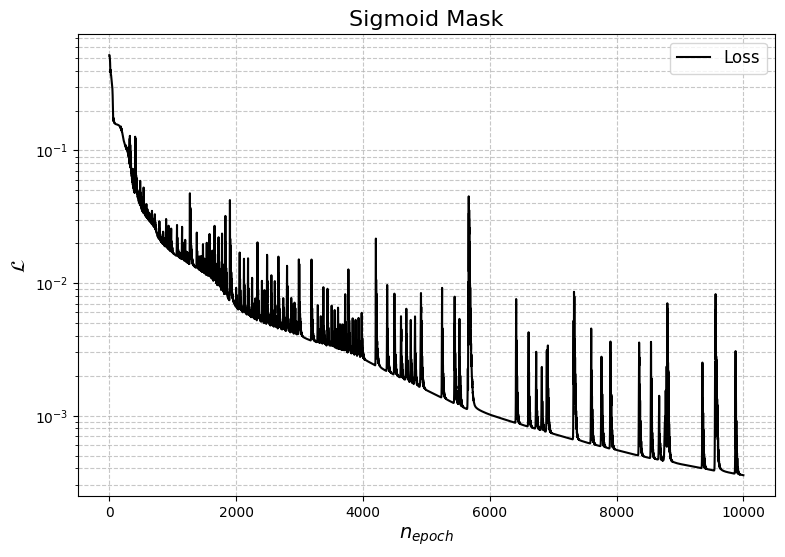

In [29]:
plot_loss(eval_loss, title=sigm_name)

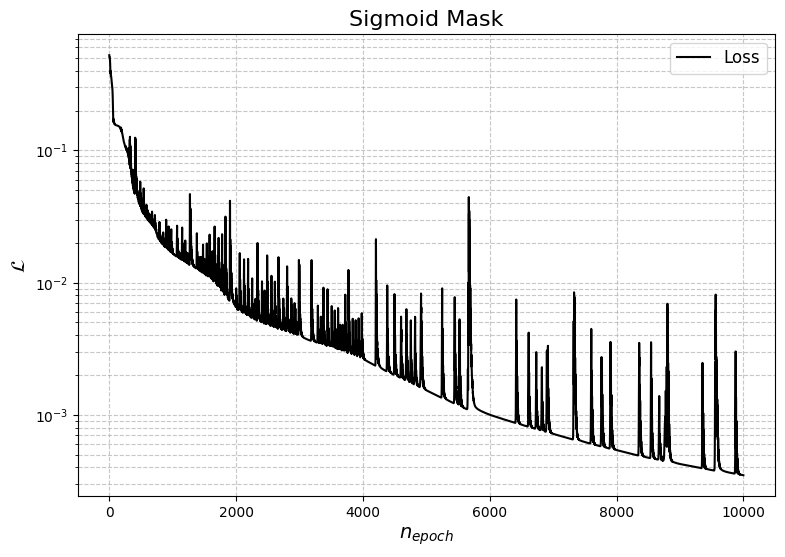

In [30]:
plot_loss(train_loss, title=sigm_name)

In [31]:
save_u_results(T, X, U, os.path.join("..", "data", "sapinn_mask", "sigm.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "sapinn_mask", "sigm.json"))
save_model(poly_sapinn, os.path.join("..", "saved_models", "sapinn_mask", "sigm.pt"))

# SAPINN with linear mask function

In [32]:
# Set training parameters
lin_name = "Linear Mask"
lin_sapinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    rff_features=rff_features,
    activation=torch.nn.Tanh(),
    mask_class=LinearMask,
    hidden_layers= 9 * [2 * rff_features + 2],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizers = {
    "model": optim.Adam(lin_sapinn.u_model.parameters(), lr=1e-3),
    "lambdas_pde": optim.Adam([lin_sapinn.lambdas_pde], lr=lambda_lr),
    "lambdas_ics": optim.Adam([lin_sapinn.lambdas_ics], lr=lambda_lr),
    "lambdas_bcs": optim.Adam([lin_sapinn.lambdas_bcs], lr=lambda_lr)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9)
}

In [33]:
lin_sapinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    lin_sapinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

Epoch: 50/10000, PINN Loss: 0.29838094115257263, True Loss: 0.29417508840560913
Epoch: 100/10000, PINN Loss: 0.16045859456062317, True Loss: 0.1608717441558838
Epoch: 150/10000, PINN Loss: 0.1462457776069641, True Loss: 0.14592599868774414
Epoch: 200/10000, PINN Loss: 0.11490430682897568, True Loss: 0.11407780647277832
Epoch: 250/10000, PINN Loss: 0.0983196347951889, True Loss: 0.09779183566570282
Epoch: 300/10000, PINN Loss: 0.08819985389709473, True Loss: 0.06410825252532959
Epoch: 350/10000, PINN Loss: 0.053166259080171585, True Loss: 0.05729333311319351
Epoch: 400/10000, PINN Loss: 0.041455574333667755, True Loss: 0.04347769170999527
Epoch: 450/10000, PINN Loss: 0.03189021721482277, True Loss: 0.031731996685266495
Epoch: 500/10000, PINN Loss: 0.02841717191040516, True Loss: 0.028500311076641083
Epoch: 550/10000, PINN Loss: 0.02635026164352894, True Loss: 0.02597665786743164
Epoch: 600/10000, PINN Loss: 0.023728299885988235, True Loss: 0.025169994682073593
Epoch: 650/10000, PINN Los

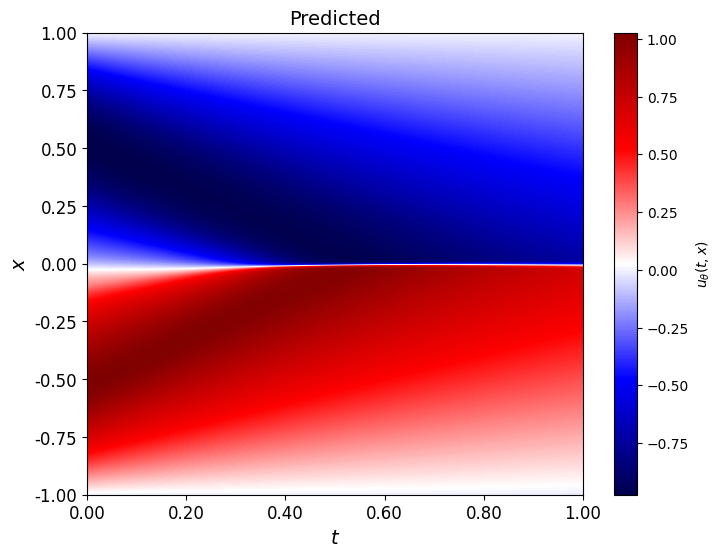

In [34]:
N = 500
lin_sapinn.to("cpu")
T, X, U = compute_approximation_2d(lin_sapinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

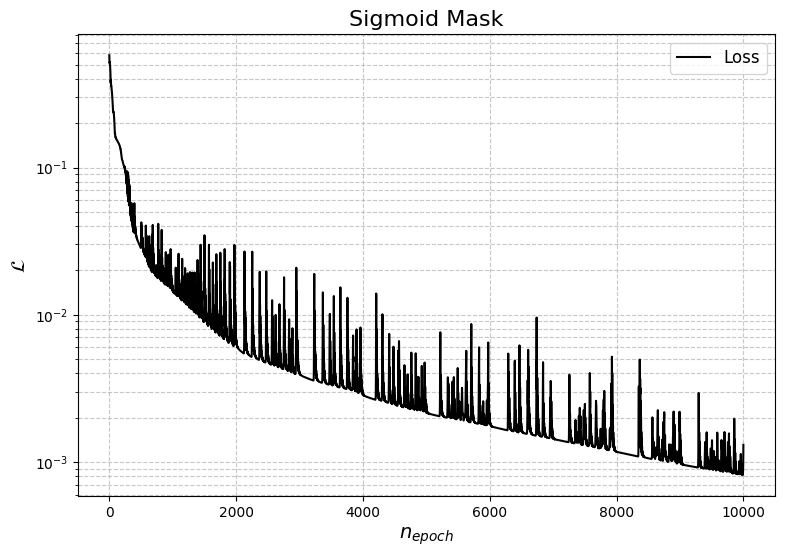

In [35]:
plot_loss(eval_loss, title=sigm_name)

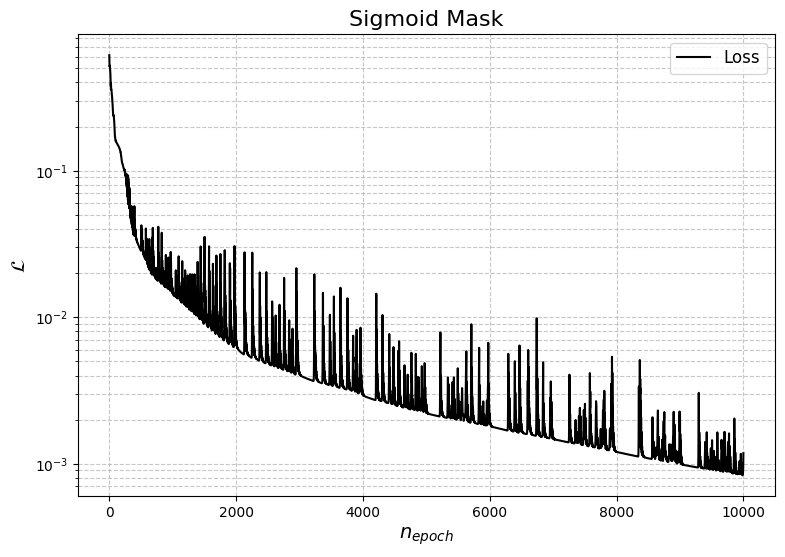

In [36]:
plot_loss(train_loss, title=sigm_name)

In [37]:
save_u_results(T, X, U, os.path.join("..", "data", "sapinn_mask", "lin.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "sapinn_mask", "lin.json"))
save_model(poly_sapinn, os.path.join("..", "saved_models", "sapinn_mask", "lin.pt"))

# Comparasion

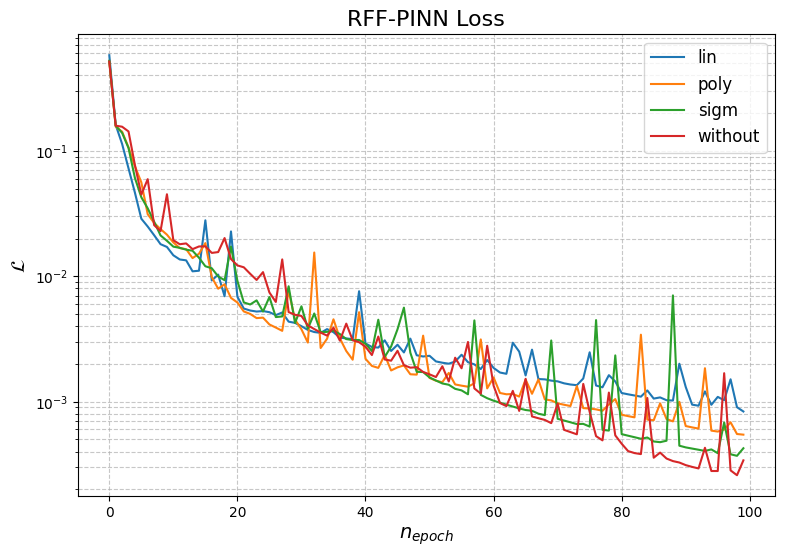

In [41]:
# отрисовка сохраненных графиков
mask_path = ["lin", "poly", "sigm", "without"]
losses = dict(zip(mask_path, [None] * len(mask_path)))
for mask in mask_path:
    with open(os.path.join("..", "data", "sapinn_mask", f"{mask}.json")) as f:
        data = json.load(f)
    losses[mask] = data[::100]
plot_loss(
    losses, title="RFF-PINN Loss",
    # save_path=os.path.join("..", "pics", "1d_burgers", "loss", "rff_pinn_v001divpi.png")
)